<h1>AdaBoost Regression</h1>
<p>
    Model created using Scikit Learn. Datasets gathered from <a href = "https://www.coindesk.com">CoinDesk.</a>
    <br/>
    AdaBoost - Adaptive Boosting - is a subset of boosting models, boosting models springs from the idea of using multiple base prediction models (learners) to generate one stronger learner, the base learners are usually weak, however they could also be strong learners. AdaBoost is applicable to both classification and regression problems. In AdaBoost, subsequence learners that are generated after the first leraner is generated to cover the previous learner weakness. The most common type of AdaBoost uses simple decision trees models, offenly called stumps, as its base learner; this utilization of AdaBoost will also uses stumps as the base learners.
</p>

In [117]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math as ma

%matplotlib inline

In [214]:
def get_csv(path: str) -> pd.DataFrame:
    
    return pd.read_csv(path, parse_dates = ['Date'])\
        .drop(columns = ['Currency', '24h Open (USD)'])\
        .rename(columns = {'Date': 'date', 'Closing Price (USD)': 'price', '24h High (USD)': 'high', '24h Low (USD)': 'low'})


def transform_df(df: pd.DataFrame) -> pd.DataFrame:

    transformed_df = pd.DataFrame(columns = ['date', 'price', 'previous price', 'previous high', 'previous low'])

    for i in range(1, df.shape[0]):
        transformed_df.loc[i - 1] = {'date': df.loc[i]['date'], 'price': df.loc[i]['price'], 'previous price': df.loc[i - 1]['price'], 'previous high': df.loc[i - 1]['high'], 'previous low': df.loc[i - 1]['low']}

    return transformed_df

    
def MAPE(pred, real) -> float:
    '''
    Returns MAPE in decimal.
    '''
    return np.mean(abs(1 - (pred / real)))


def RMSE(pred, real):
    return np.sqrt(np.mean((real - pred) ** 2))


def plot_graph(*args, title: str = None, **kwargs) -> None:
    plt.figure(figsize = (20, 6))
    
    if title is not None:
        plt.title(title)
    
    for arg in args:
        plt.plot(arg)

    for kw in kwargs:
        plt.plot(kwargs[kw], label = kw)

    if len(kwargs) > 0:
        plt.legend(loc = 'best')

    plt.show()

In [119]:
df_ada = transform_df(get_csv('./data/cardano.csv'))

<p>
    Spliting data into train and test.
</p>

In [120]:
train_x_ada = df_ada[['previous price', 'previous high', 'previous low']][:ma.floor(df_ada.shape[0] * 0.7)].to_numpy()
train_y_ada = df_ada['price'][:ma.floor(df_ada.shape[0] * 0.7)]
test_x_ada  = df_ada[['previous price', 'previous high', 'previous low']][ma.floor(df_ada.shape[0] * 0.7):].to_numpy()
test_y_ada  = df_ada['price'][ma.floor(df_ada.shape[0] * 0.7):]

<p>
    AdaBoost using 30 Decision tree regressors as the base models.
</p>

In [121]:
model_ada = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth = 4), n_estimators = 30).fit(train_x_ada, train_y_ada)
pred_ada = pd.Series(model_ada.predict(test_x_ada), index = test_y_ada.index)

In [122]:
MAPE(pred_ada, test_y_ada) * 100

4.362038666531758

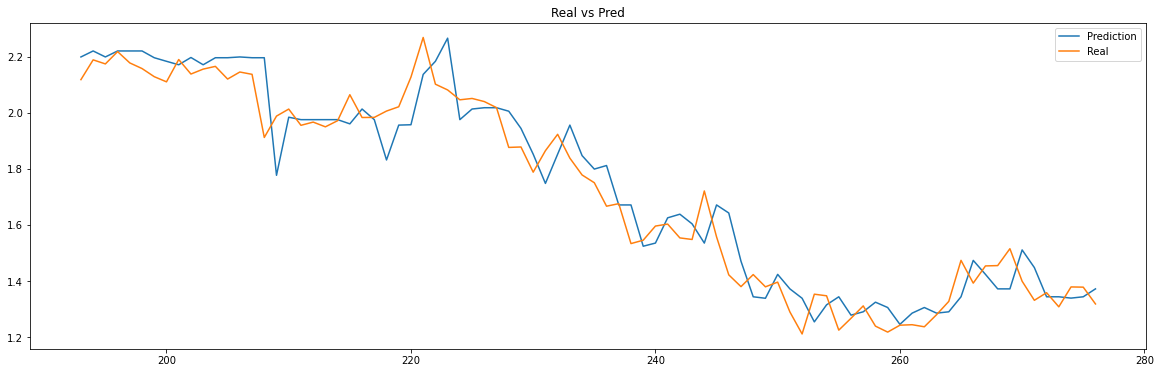

In [217]:
plot_graph(title = 'Real vs Pred', Prediction = pred_ada, Real = test_y_ada)

In [163]:
def n_estimators_test(df: pd.DataFrame, max_depth: int = 3, max_estimators: int = 100, test_ratio: float = 0.3) -> pd.Series:
    result = pd.Series(dtype = np.float64)

    for n_estimators in range(1, max_estimators + 1):
        train_x = df[['previous price', 'previous high', 'previous low']][:ma.floor(df.shape[0] * (1 - test_ratio))].to_numpy()
        train_y = df['price'][:ma.floor(df.shape[0] * (1 - test_ratio))]
        test_x = df[['previous price', 'previous high', 'previous low']][ma.floor(df.shape[0] * (1 - test_ratio)):].to_numpy()
        test_y = df['price'][ma.floor(df.shape[0] * (1 - test_ratio)):]

        model = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth = max_depth), n_estimators = n_estimators)
        model.fit(train_x, train_y)
        pred = model.predict(test_x)
        mape = np.mean(abs(1 - (pred / test_y)))
        result.loc[n_estimators] = mape

    return result

In [148]:
n_estimators = n_estimators_test(df_ada, max_depth = 4)

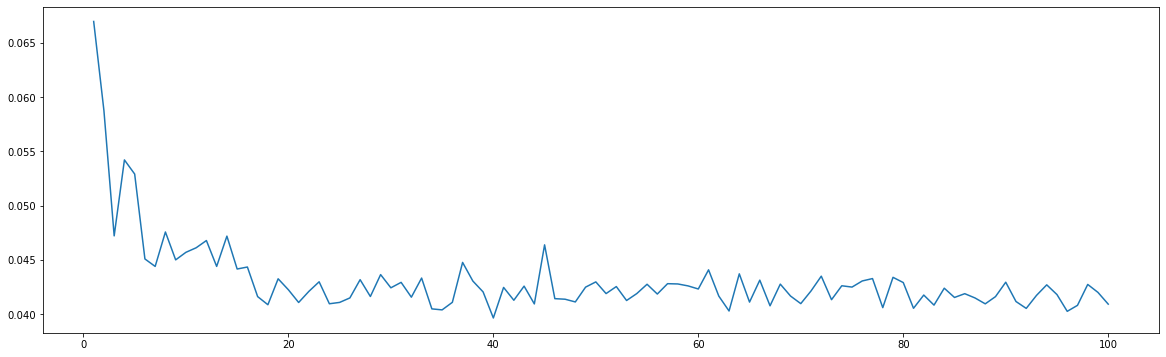

In [205]:
plot_graph(n_estimators)

In [152]:
n_estimators.sort_values().head()

40    0.039653
96    0.040265
63    0.040297
35    0.040399
34    0.040491
dtype: float64

In [128]:
model_ada = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth = 4), n_estimators = 40).fit(train_x_ada, train_y_ada)
pred_ada = pd.Series(model_ada.predict(test_x_ada), index = test_y_ada.index)

In [129]:
MAPE(pred_ada, test_y_ada) * 100

4.315818144857281

In [130]:
RMSE(pred_ada, test_y_ada)

0.09109476283049228

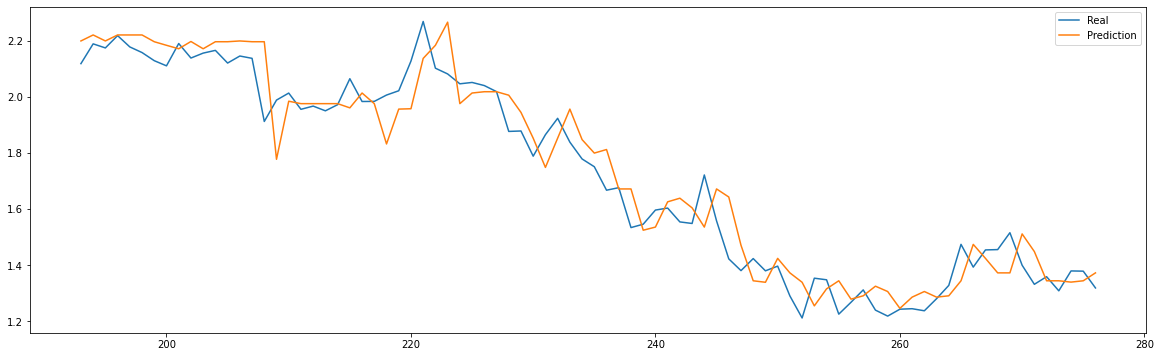

In [206]:
plot_graph(Real = test_y_ada, Prediction = pred_ada)

In [218]:
def rolling_adaboost(df: pd.DataFrame, max_depth: int = 3, n_estimators: int = 50, test_ratio: float = 0.3) -> pd.DataFrame:
    test_x = df[['previous price', 'previous high', 'previous low']][ma.floor(df.shape[0] * (1 - test_ratio)):]
    test_y = df['price'][ma.floor(df.shape[0] * (1 - test_ratio)):]
    pred = pd.DataFrame(columns = ['pred', 'real'], dtype = np.float64)

    for i in test_y.index:
        train_x = df[['previous price', 'previous high', 'previous low']][:i].to_numpy()
        train_y = df['price'][:i]
        model = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth = max_depth), n_estimators = n_estimators)
        model.fit(train_x, train_y)
        pred.loc[i] ={'pred': model.predict([test_x.loc[i].to_numpy()])[0], 'real': test_y.loc[i]}
        
    return pred

In [219]:
rolling_ada = rolling_adaboost(df_ada, 4, 49)

In [221]:
MAPE(rolling_ada['pred'], rolling_ada['real']) * 100

3.935109830788308

In [135]:
RMSE(rolling_ada['pred'], rolling_ada['real'])

0.08360493455322239

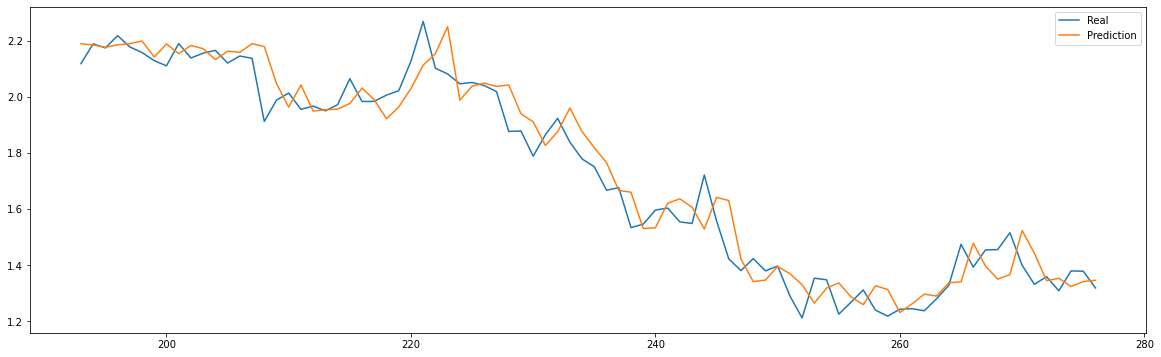

In [222]:
plot_graph(Real = rolling_ada['real'], Prediction = rolling_ada['pred'])

In [153]:
df_eth = transform_df(get_csv('./data/ethereum.csv'))
df_doge = transform_df(get_csv('./data/dogecoin.csv'))
df_sol = transform_df(get_csv('./data/solana.csv'))

In [182]:
n_estimators_eth = n_estimators_test(df_eth, test_ratio = 0.1)

In [183]:
n_estimators_eth.sort_values().head()

64    0.060330
37    0.061414
83    0.061763
62    0.061921
85    0.062562
dtype: float64

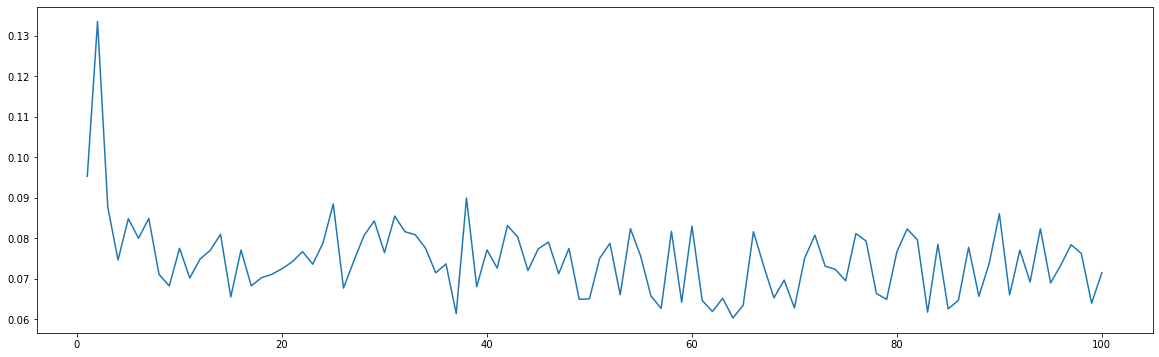

In [208]:
plot_graph(n_estimators_eth)

In [186]:
rolling_eth = rolling_adaboost(df_eth, n_estimators = 60)

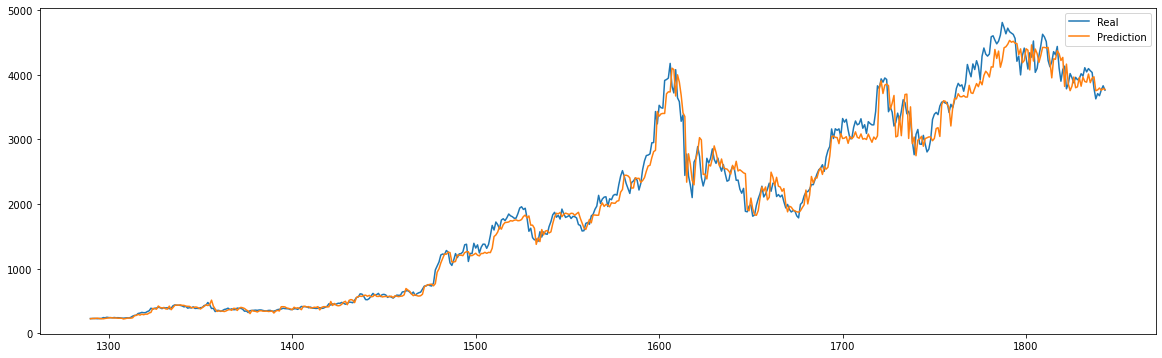

In [209]:
plot_graph(Real = rolling_ada['real'], Prediction = rolling_eth['pred'])

In [192]:
MAPE(rolling_eth['pred'], rolling_eth['real'])

0.05581518177280786